In [1]:
# importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
# importing training data
path1 = '/content/gdrive/My Drive/predict-forclosure-probability/cleaned_traindt.xlsx'
traindf = pd.read_excel(path1)

In [4]:
# # importing test data
# path2 = '/content/gdrive/My Drive/cleaned_testdt.xlsx'
# testdf = pd.read_excel(path2)

In [12]:
traindf.shape

(19731, 66)

Converting the Categorical features to Numeric by encoding the labels manually

In [13]:
gender = ['M','F']
M_S = ['M','S']

In [14]:
traindf.MARITAL_STATUS.unique()

array(['M', nan, 'S'], dtype=object)

In [15]:
traindf.QUALIFICATION.unique()

array(['POSTGRAD', 'GRAD', 'UG', nan, 'OTHERS', 'PRF', 'DOCTRATE', 'ENG',
       'MAT'], dtype=object)

In [16]:
edu = ['MAT','UG','GRAD','ENG','POSTGRAD','DOCTRATE','PRF','OTHERS']

In [17]:
traindf.SEX.replace(gender,value=[1,0],inplace=True)

In [18]:
traindf.MARITAL_STATUS.replace(M_S,value=[1,0],inplace=True)
traindf.QUALIFICATION.replace(edu,value=[0,1,2,3,4,5,6,-1],inplace=True)

Now,The input data is prepared from the train data to be fed in any model.We remove fatures like agreement id,interest start date,city,last receipt date,product,scheme id and the target variable(foreclosure).There are many missing values in the original dataframe,which is data quality issue,so in order to remove NaNs, a large negative constant value is inserted in place,which would be ignored by the model as an outlier.            



In [19]:
X = traindf.drop(['AGREEMENTID','CUSTOMERID','INTEREST_START_DATE','CITY','LAST_RECEIPT_DATE','PRODUCT','SCHEMEID','FORECLOSURE','DPD-1','DPD-2','DPD-3','DPD-4','DPD-5','DPD-6'],axis=1)
X.fillna(-9999,axis=1,inplace=True)
X.head(10)

,NET_DISBURSED_AMT,CURRENT_ROI,ORIGNAL_ROI,CURRENT_TENOR,ORIGNAL_TENOR,PRE_EMI_DUEAMT,PRE_EMI_RECEIVED_AMT,PRE_EMI_OS_AMOUNT,EMI_DUEAMT,EMI_RECEIVED_AMT,EMI_OS_AMOUNT,EXCESS_AVAILABLE,EXCESS_ADJUSTED_AMT,BALANCE_EXCESS,NET_RECEIVABLE,OUTSTANDING_PRINCIPAL,PAID_PRINCIPAL,PAID_INTEREST,MONTHOPENING,LAST_RECEIPT_AMOUNT,NET_LTV,COMPLETED_TENURE,BALANCE_TENURE,DPD,FOIR,NPA_IN_LAST_MONTH,NPA_IN_CURRENT_MONTH,CUST_CONSTTYPE_ID,AGE,SEX,MARITAL_STATUS,QUALIFICATION,NO_OF_DEPENDENT,NETTAKEHOMEINCOME,PaidPrn-1,PaidPrn-2,PaidPrn-3,PaidPrn-4,PaidPrn-5,PaidPrn-6,PaidIntrst-1,PaidIntrst-2,PaidIntrst-3,PaidIntrst-4,PaidIntrst-5,PaidIntrst-6,EmiDue-1,EmiDue-2,EmiDue-3,EmiDue-4,EmiDue-5,EmiDue-6
0,11710107.24,13.42,10.61,45,120,7994.27,7994.27,0.0,8614898.28,8439420.50,175477.78,213586.86,213586.86,0.00,175477.78,116447.23,11593660.01,2725722.88,8693575.33,1000000.0,40.06,45,0,0.0,0.60,-9999.0,-9999.0,1.0,33.0,1.0,1.0,4.0,0.0,198375.22,9982394.87,9873401.90,9765376.67,9658310.58,9552640.58,9447930.42,2710245.45,2693791.64,2676370.10,2657989.42,2638212.64,2617476.02,184544.40,184544.40,0.00,184544.40,184544.40,184544.40
1,19290253.32,13.73,10.61,137,180,100504.58,100504.58,0.0,10619027.21,10339579.13,279448.08,0.00,0.00,0.00,279448.08,12347597.30,6942656.03,4945153.59,17138606.02,126530.0,84.31,38,99,0.0,0.60,-9999.0,-9999.0,1.0,44.0,1.0,1.0,4.0,0.0,242703.98,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00
2,3933395.00,15.61,11.55,312,180,5947.63,5947.63,0.0,4670210.68,4670210.68,0.00,1179715.72,1179715.72,0.00,0.00,2994183.52,939211.48,2990124.01,3744831.42,22878.0,50.89,81,231,0.0,0.72,-9999.0,-9999.0,3.0,43.0,1.0,1.0,2.0,0.0,53536.21,936086.79,932994.31,929933.73,926904.68,924444.55,922093.00,2958902.06,2927647.89,2896361.83,2865044.23,2833157.71,2801162.62,0.00,0.00,0.00,0.00,0.00,0.00
3,10022587.71,11.24,10.61,91,180,60322.18,60322.18,0.0,13130976.81,13067317.53,63659.28,6770848.42,6770848.42,0.00,63659.28,42951.20,9979636.50,4648994.27,5747875.24,65741.0,84.63,91,0,0.0,0.60,-9999.0,-9999.0,1.0,33.0,1.0,1.0,4.0,0.0,123370.48,9881994.27,9785078.90,9688884.98,9593407.14,9498640.07,9404578.45,4647939.82,4646158.51,4643655.74,4640436.89,4636507.28,4631872.21,145192.42,145192.42,145192.42,145192.42,145192.42,145192.42
4,7755937.31,14.98,10.92,304,180,27732.79,27732.79,0.0,10489232.82,10489232.82,0.00,120218.11,120218.11,0.00,0.00,7200652.61,555284.70,6593777.81,7200652.61,54433.0,30.94,89,215,0.0,0.83,-9999.0,-9999.0,3.0,37.0,1.0,1.0,1.0,0.0,93803.84,545667.34,536145.20,526717.35,517382.83,508140.74,498990.16,6521675.14,6449477.23,6377185.05,6304799.54,6232321.60,6159752.14,0.00,0.00,0.00,0.00,0.00,0.00
5,954408.27,12.42,10.61,235,180,1325.13,1325.13,0.0,1355118.92,1341291.17,13827.74,27655.49,27655.49,0.00,13827.74,769138.61,185269.66,727393.58,769138.61,6261.0,23.24,98,137,0.0,0.60,-9999.0,-9999.0,1.0,30.0,1.0,1.0,2.0,0.0,35880.97,182272.34,179299.67,175868.86,172464.15,169085.35,165601.78,720991.29,714564.35,708595.54,702600.64,696579.83,690663.78,13827.74,13827.74,13827.74,13827.74,13827.74,13827.74
6,6605701.52,16.17,10.92,390,300,37790.53,37790.53,0.0,9101193.23,8910126.97,191066.25,95533.13,95533.13,0.00,191066.25,5765533.27,840168.25,5692699.41,6215922.01,43256.0,60.69,96,294,56.0,0.55,-9999.0,-9999.0,1.0,33.0,1.0,1.0,2.0,0.0,63576.87,834384.19,828182.25,828182.25,828182.25,822042.71,815136.98,5633543.41,5574805.31,5574805.31,5574805.31,5516004.79,5457970.47,191066.25,0.00,95533.13,191066.25,0.00,0.00
7,32960335.26,13.42,10.61,328,300,225932.66,225932.66,0.0,23013014.66,22548706.36,464308.30,464308.30,464308.30,0.00,464308.30,32251026.94,709308.32,14772088.50,32251026.94,210232.0,87.75,52,276,0.0,0.60,-9999.0,-9999.0,1.0,32.0,1.0,1.0,4.0,0.0,331757.85,682840.48,656608.34,630608.90,604839.15,579299.11,553985.76,14482935.92,14193547.64,13903926.67,13614075.99,13323995.62,13033688.55,464308.30,464308.30,464308.30,464308.30,46430

In [20]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19731 entries, 0 to 19730
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   NET_DISBURSED_AMT      19731 non-null  float64
 1   CURRENT_ROI            19731 non-null  float64
 2   ORIGNAL_ROI            19731 non-null  float64
 3   CURRENT_TENOR          19731 non-null  int64  
 4   ORIGNAL_TENOR          19731 non-null  int64  
 5   PRE_EMI_DUEAMT         19731 non-null  float64
 6   PRE_EMI_RECEIVED_AMT   19731 non-null  float64
 7   PRE_EMI_OS_AMOUNT      19731 non-null  float64
 8   EMI_DUEAMT             19731 non-null  float64
 9   EMI_RECEIVED_AMT       19731 non-null  float64
 10  EMI_OS_AMOUNT          19731 non-null  float64
 11  EXCESS_AVAILABLE       19731 non-null  float64
 12  EXCESS_ADJUSTED_AMT    19731 non-null  float64
 13  BALANCE_EXCESS         19731 non-null  float64
 14  NET_RECEIVABLE         19731 non-null  float64
 15  OU

In [21]:
Y = traindf.FORECLOSURE

In [22]:
print(X.shape)
print(Y.value_counts())

(19731, 52)
0    17936
1     1795
Name: FORECLOSURE, dtype: int64


# Baseline Model

Splitting the gold training data to train-validation-test set 

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,random_state=42,stratify=Y)
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.3,random_state=24,stratify= Y_train)
print(y_valid.value_counts())

0    3767
1     377
Name: FORECLOSURE, dtype: int64


 Training without Lag features to check model performance

In [26]:
x1 = x_train.iloc[:,0:34]
x2 = x_valid.iloc[:,0:34]

In [ ]:
clf1 = RandomForestClassifier(class_weight='balanced_subsample',n_jobs=-1)
clf1.fit(x1,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [ ]:
pred1 = clf1.predict(x2)
report1 = classification_report(y_valid,pred1,output_dict=True)
report1 = pd.DataFrame(report1)
report1

,0,1,accuracy,macro avg,weighted avg
precision,0.938219,0.890411,0.936535,0.914315,0.933870
recall,0.995753,0.344828,0.936535,0.670290,0.936535
f1-score,0.966130,0.497132,0.936535,0.731631,0.923463
support,3767.000000,377.000000,0.936535,4144.000000,4144.000000


Now training with lag features to compare

In [ ]:
clf2 = RandomForestClassifier(class_weight='balanced_subsample',n_jobs=-1)
clf2.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [ ]:
pred2 = clf2.predict(x_valid)
report2 = classification_report(y_valid,pred2,output_dict=True)
report2 = pd.DataFrame(report2)
report2

,0,1,accuracy,macro avg,weighted avg
precision,0.937187,0.851351,0.934122,0.894269,0.929378
recall,0.994160,0.334218,0.934122,0.664189,0.934122
f1-score,0.964833,0.480000,0.934122,0.722417,0.920726
support,3767.000000,377.000000,0.934122,4144.000000,4144.000000


Setting up the search space for hyper-parameter tuning.

In [ ]:
# param_grid = {'n_estimators':[100,200,300,400,500],
#               'criterion':['entropy','gini'],
#               'max_depth':[5,10,15,20],
#               'max_features':['sqrt','log2',None]}
              

In [ ]:
# RandomSearchCV
# randsearch_rf = RandomizedSearchCV(clf1,param_grid,n_jobs=-1,cv=10,scoring='f1')
# randsearch_rf.fit(x_train,y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced_subsample',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0

In [ ]:
# randsearch_rf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=15, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

Random forest classifier with the best hyper-parameters from randomized search

In [24]:
best_rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=15, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

 Hyperparameterized Random Forest trained on lag features

In [ ]:
best_rf.fit(x_train,y_train)
pred = best_rf.predict(x_valid)
report = classification_report(y_valid,pred,output_dict=True)
report = pd.DataFrame(report)
report

,0,1,accuracy,macro avg,weighted avg
precision,0.946314,0.669323,0.929537,0.807818,0.921115
recall,0.977967,0.445623,0.929537,0.711795,0.929537
f1-score,0.961880,0.535032,0.929537,0.748456,0.923047
support,3767.000000,377.000000,0.929537,4144.000000,4144.000000


Hyperparameterized Random Forest trained without the lag features

In [27]:
best_rf.fit(x1,y_train)
pred = best_rf.predict(x2)
report = classification_report(y_valid,pred,output_dict=True)
report = pd.DataFrame(report)
report

,0,1,accuracy,macro avg,weighted avg
precision,0.952209,0.703297,0.935811,0.827753,0.929564
recall,0.978497,0.509284,0.935811,0.743891,0.935811
f1-score,0.965174,0.590769,0.935811,0.777972,0.931113
support,3767.000000,377.000000,0.935811,4144.000000,4144.000000


The inclusion of lag features seems to worsen the model performance. The model performs better without it.Creating Lag features for time series problems is the most fundamental approach that is taken to solve such problem, the only explanation for its failure here in this case is because of the simulated nature of the data. Had the dataset been acquired from a legitimate source lag features would have definitely made a difference.

feature importance score from our best random forest model

In [28]:
imp_feature = best_rf.feature_importances_
np.set_printoptions(suppress=True)
len(imp_feature)

34

Arranging the features in a dataframe,with the most important feature at first.

In [29]:
feature_names = x1.columns
tup= sorted(zip(imp_feature,feature_names), reverse=True)
impf = pd.DataFrame(tup, columns=['importance', 'feature'])
impf

,importance,feature
0,0.067853,ORIGNAL_ROI
1,0.064867,AGE
2,0.062777,CURRENT_ROI
3,0.062610,NETTAKEHOMEINCOME
4,0.044262,NO_OF_DEPENDENT
5,0.042961,COMPLETED_TENURE
6,0.042217,CUST_CONSTTYPE_ID
7,0.038481,PAID_INTEREST
8,0.038314,QUALIFICATION
9,0.036378,MARITAL_STATUS


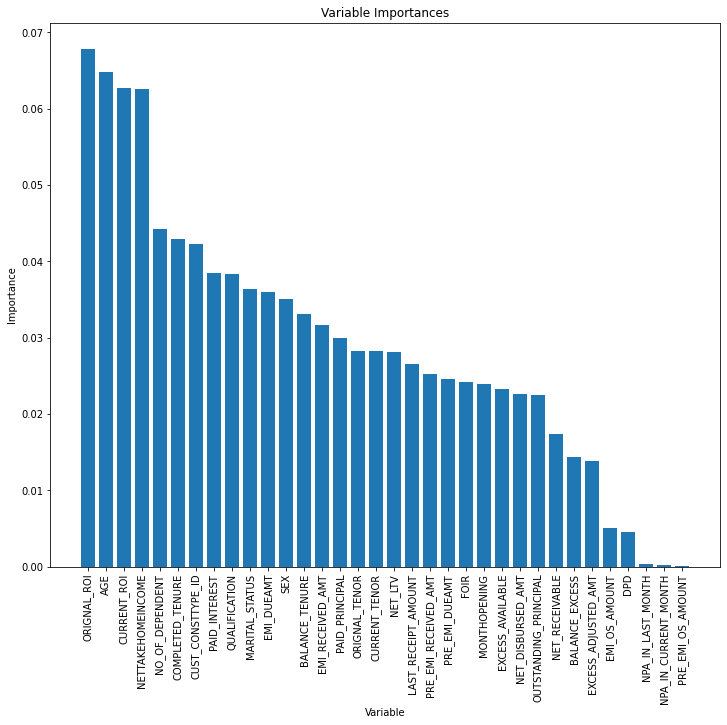

In [30]:
# Feature importance graph
score= list(impf['importance'])
feature= list(impf['feature'])
plt.figure(figsize=(12,10))
plt.bar(range(len(tup)), score, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(range(len(tup)), feature, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()

## Performing Feature selection

We make use of the backward feature elimination method

In [ ]:
# thresholds = np.sort(imp_feature)

In [ ]:
# for thresh in thresholds:
#     # select features using threshold
#     selection = SelectFromModel(best_rf,threshold=thresh).fit(x1,y_train)
#     select_X_train = selection.transform(x1)
#     select_X_test = selection.transform(x2)
#     # train model
#     selection_model = best_rf
#     selection_model.fit(select_X_train, y_train)
#     # eval model
    
#     y_pred = selection_model.predict(select_X_test)
#     predictions = [round(value) for value in y_pred]
#     accuracy = accuracy_score(y_valid, predictions)  
#     print("Thresh=%.3f, n=%d, Accuracy: %.2f%%"%(thresh, select_X_train.shape[1], accuracy*100.0))

The performance of the model peaks at around top 23 features out of the total of 34 features.

In [ ]:
select_ftr = list(impf.iloc[0:23,1])
select_X = x1[select_ftr]
select_X.head()

,ORIGNAL_ROI,NETTAKEHOMEINCOME,CURRENT_ROI,AGE,COMPLETED_TENURE,NO_OF_DEPENDENT,MARITAL_STATUS,PAID_INTEREST,QUALIFICATION,SEX,EMI_DUEAMT,EMI_RECEIVED_AMT,BALANCE_TENURE,PAID_PRINCIPAL,CUST_CONSTTYPE_ID,CURRENT_TENOR,NET_LTV,ORIGNAL_TENOR,LAST_RECEIPT_AMOUNT,PRE_EMI_RECEIVED_AMT,PRE_EMI_DUEAMT,FOIR,MONTHOPENING
14348,12.42,-9999.00,12.42,-9999.0,3,-9999.0,-9999.0,232310.51,-9999.0,-9999.0,161215.46,161215.46,237,15229.14,-9999.0,240,89.97,240,24332.0,202939.43,202939.43,0.44,3783049.23
17974,16.17,-9999.00,16.17,-9999.0,2,-9999.0,-9999.0,83961.47,-9999.0,-9999.0,77392.08,77392.08,238,4023.47,-9999.0,240,43.28,240,17521.0,52042.32,52042.32,0.45,2247920.23
4931,14.98,73661.83,14.98,36.0,17,0.0,1.0,488189.87,1.0,1.0,862943.11,862943.11,163,106075.56,1.0,180,55.54,180,22984.0,11279.08,11279.08,0.58,2768905.90
4489,14.55,-9999.00,14.55,-9999.0,9,-9999.0,-9999.0,819878.65,-9999.0,-9999.0,12202609.79,12202609.79,5,7533326.67,-9999.0,14,20.29,14,2456.0,85766.91,85766.91,2.21,4477039.73
3507,17.48,99085.52,17.48,40.0,39,0.0,1.0,598315.92,1.0,1.0,1028951.13,1028951.13,141,108985.07,1.0,180,32.23,180,11950.0,11557.35,11557.35,0.20,1237677.27


In [ ]:
select_X.shape

(9667, 23)

In [ ]:
# Make use of x_train, best features, rf model and trying on valid
select_xValid = x2[select_ftr]
clasif = best_rf
clasif.fit(select_X,y_train)
predict = clasif.predict(select_xValid)
result = classification_report(y_valid,predict,output_dict=True)
result = pd.DataFrame(result)
result

,0,1,accuracy,macro avg,weighted avg
precision,0.954121,0.699301,0.936535,0.826711,0.930939
recall,0.977170,0.530504,0.936535,0.753837,0.936535
f1-score,0.965508,0.603318,0.936535,0.784413,0.932558
support,3767.000000,377.000000,0.936535,4144.000000,4144.000000


Selecting the right features and tuned random forest model does seem to improve the model from the previous baseline.

## Oversampling minority class

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
X_resampled, y_resampled = SMOTE().fit_resample(x1, y_train)

In [ ]:
y_resampled = pd.Series(y_resampled)
X_resampled = pd.DataFrame(X_resampled,columns=x1.columns)

In [ ]:
X_resampled.head()

,NET_DISBURSED_AMT,CURRENT_ROI,ORIGNAL_ROI,CURRENT_TENOR,ORIGNAL_TENOR,PRE_EMI_DUEAMT,PRE_EMI_RECEIVED_AMT,PRE_EMI_OS_AMOUNT,EMI_DUEAMT,EMI_RECEIVED_AMT,EMI_OS_AMOUNT,EXCESS_AVAILABLE,EXCESS_ADJUSTED_AMT,BALANCE_EXCESS,NET_RECEIVABLE,OUTSTANDING_PRINCIPAL,PAID_PRINCIPAL,PAID_INTEREST,MONTHOPENING,LAST_RECEIPT_AMOUNT,NET_LTV,COMPLETED_TENURE,BALANCE_TENURE,DPD,FOIR,NPA_IN_LAST_MONTH,NPA_IN_CURRENT_MONTH,CUST_CONSTTYPE_ID,AGE,SEX,MARITAL_STATUS,QUALIFICATION,NO_OF_DEPENDENT,NETTAKEHOMEINCOME
0,3798278.37,12.42,12.42,240.0,240.0,202939.43,202939.43,0.0,161215.46,161215.46,0.0,260.61,0.00,260.61,-260.61,3783049.23,15229.14,232310.51,3783049.23,24332.0,89.97,3.0,237.0,0.0,0.44,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.00
1,2251943.70,16.17,16.17,240.0,240.0,52042.32,52042.32,0.0,77392.08,77392.08,0.0,3458.59,260.61,3197.98,-3197.98,2247920.23,4023.47,83961.47,2247920.23,17521.0,43.28,2.0,238.0,0.0,0.45,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.00
2,2874981.46,14.98,14.98,180.0,180.0,11279.08,11279.08,0.0,862943.11,862943.11,0.0,1.10,0.00,1.10,-1.10,2768905.90,106075.56,488189.87,2768905.90,22984.0,55.54,17.0,163.0,0.0,0.58,-9999.0,-9999.0,1.0,36.0,1.0,1.0,1.0,0.0,73661.83
3,12010366.40,14.55,14.55,14.0,14.0,85766.91,85766.91,0.0,12202609.79,12202609.79,0.0,3.38,0.00,3.38,-3.38,4477039.73,7533326.67,819878.65,4477039.73,2456.0,20.29,9.0,5.0,0.0,2.21,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.00
4,1346662.33,17.48,17.48,180.0,180.0,11557.35,11557.35,0.0,1028951.13,1028951.13,0.0,5217.66,2117.74,3099.92,-3099.92,1237677.27,108985.07,598315.92,1237677.27,11950.0,32.23,39.0,141.0,0.0,0.20,-9999.0,-9999.0,1.0,40.0,1.0,1.0,1.0,0.0,99085.52


In [ ]:
X_resampled.shape

(17576, 34)

In [ ]:
y_resampled.value_counts()

1    8788
0    8788
dtype: int64

In [ ]:
Select_X = X_resampled[select_ftr]
Select_X.shape

(17576, 23)

## Training with Oversampling

In [ ]:
up_clasif = best_rf
up_clasif.fit(Select_X,y_resampled)
predict = up_clasif.predict(x2[select_ftr])
result = classification_report(y_valid,predict,output_dict=True)
result = pd.DataFrame(result)
result

,0,1,accuracy,macro avg,weighted avg
precision,0.962571,0.522976,0.914093,0.742774,0.922579
recall,0.942129,0.633952,0.914093,0.788041,0.914093
f1-score,0.952240,0.573141,0.914093,0.762691,0.917752
support,3767.000000,377.000000,0.914093,4144.000000,4144.000000


Training with the right set of features that is passed into the tuned model, and the minority class upsampled led to higher recall in the imbalanced validation set, which a desirable result. Since we can be okay with false positive cases but the recall should be higher for our intended application.

Performing the same exercise as above but now making use of train-validation for Training and evaluating against test.

In [ ]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train, Y_train)
y_resampled = pd.Series(y_resampled)
X_resampled = pd.DataFrame(X_resampled,columns=X_train.columns)
X_train = X_resampled[select_ftr]

up_clasif = best_rf
up_clasif.fit(X_train,y_resampled)
predict = up_clasif.predict(X_test[select_ftr])
result = classification_report(Y_test,predict,output_dict=True)
result = pd.DataFrame(result)
result

,0,1,accuracy,macro avg,weighted avg
precision,0.965583,0.520290,0.913682,0.742937,0.925040
recall,0.938487,0.666048,0.913682,0.802268,0.913682
f1-score,0.951842,0.584215,0.913682,0.768029,0.918371
support,5381.000000,539.000000,0.913682,5920.000000,5920.000000


In [ ]:
Y_test.value_counts()

0    5381
1     539
Name: FORECLOSURE, dtype: int64

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, predict)

array([[5050,  331],
       [ 180,  359]])

 ## Conclusion 

Out of all the different approaches that has been tried so far to come up with the most accurate model to identify cases of Loan Foreclosure, the best approach seems to be to tune the Random Forest Model and then make use of select important features,as this gives the highest F1 score. Oversampling does increase the overall recall of the model but the precision goes for a toss.Without oversampling, the model had a higher precision which is also desirable.As far as recall is considered, we can adjust the threshold to increase recall rate which helps the model determine, if the probability score is above a certain value,whether its a case of foreclosure or not. 

In [ ]:
prob_score = clasif.predict_proba(select_xValid)
prob_score = prob_score[:,1]

In [ ]:
d = {'class_prob':prob_score,'True_Label':y_valid}
result_df = pd.DataFrame(d)
result_df.reset_index(drop=True,inplace=True)
result_df.head()

,class_prob,True_Label
0,0.319887,0
1,0.191419,0
2,0.140611,0
3,0.010000,0
4,0.107843,0


In [ ]:
result_df.True_Label.value_counts()

0    3767
1     377
Name: True_Label, dtype: int64

In [ ]:
prob = []
a1 = list(result_df[result_df.True_Label == 0]['class_prob'].sample(frac=0.1,random_state=1))
a2 = list(result_df[result_df.True_Label == 1]['class_prob'].sample(frac=0.1,random_state=1))
prob = a1 + a2

In [ ]:
label = []
a1 = list(result_df[result_df.True_Label == 0]['True_Label'].sample(frac=0.1,random_state=1))
a2 = list(result_df[result_df.True_Label == 1]['True_Label'].sample(frac=0.1,random_state=1))
label = a1 + a2

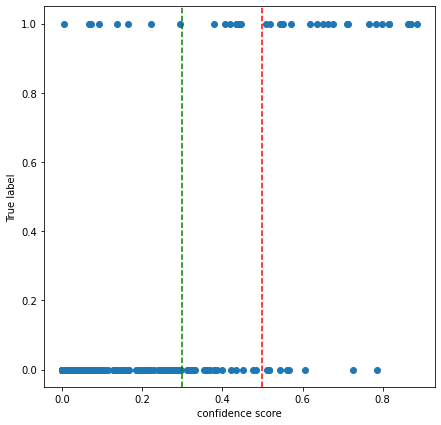

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(prob,label)
plt.axvline(x=0.5, color='r', linestyle='--')
plt.axvline(x=0.3, color='g', linestyle='--')
plt.xlabel('confidence score')
plt.ylabel('True label')
plt.show()

In the above graph, we have plotted a scatterplot, with the x axis being the class confidence scores and the y axis as the true label. In Scikit learn's implementation, the threshold value is taken as 0.5 as default(red). With that value, even though the precision of the model is high, the recall is relatively low. If the threshold is set as 0.3(green), as shown in the plot, the recall rate also increases.